# Import packages

In [ ]:
!pip install fsspec

In [ ]:
!pip install s3fs

In [ ]:
!pip install cegaltools

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from cegaltools.plotting import CegalWellPlotter as cwp
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# Import and inspect data

In [ ]:
# train = pd.read_csv("train (1).csv", sep = ";")
# test = pd.read_csv("test.csv", sep = ";")

In [ ]:
s3_train_csv = 's3://zarr-depot/wells/FORCE: Machine Predicted Lithology/train.csv'
train = pd.read_csv(s3_train_csv, sep=';')

In [ ]:
s3_test_csv = 's3://zarr-depot/wells/FORCE: Machine Predicted Lithology/test.csv'
test = pd.read_csv(s3_test_csv, sep=';')

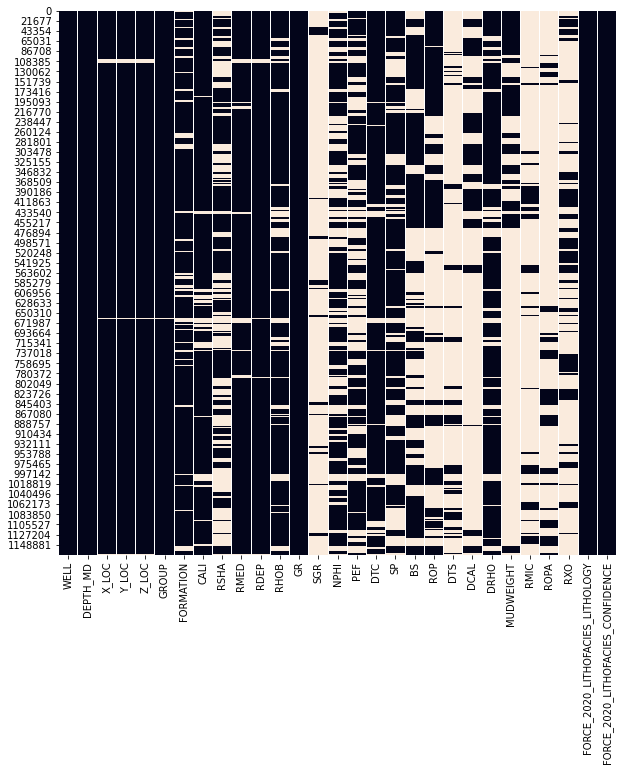

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(train.isnull(),cbar=False)

In [ ]:
lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}

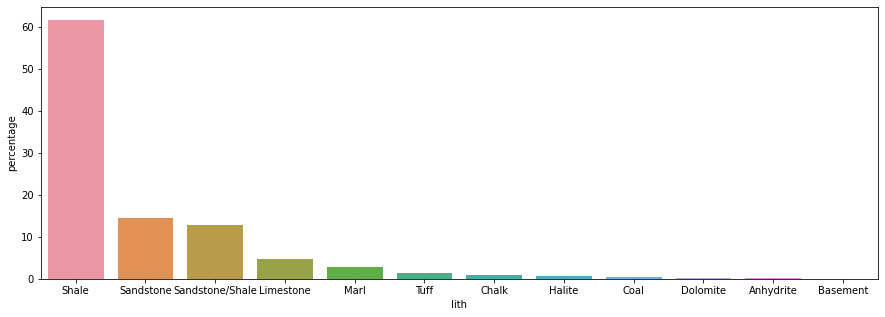

In [ ]:
lith_counts = train["FORCE_2020_LITHOFACIES_LITHOLOGY"].value_counts().reset_index()
lith_counts.columns = ['lith_id', 'counts']
lith_counts['lith'] = lith_counts['lith_id'].map(lithology_keys)
lith_counts['percentage'] = (lith_counts['counts']/lith_counts['counts'].sum()*100)

plt.figure(figsize=(15,5))
sns.barplot(x='lith',y='percentage',data=lith_counts)

In [ ]:
wells = train['WELL'].unique()
wells

array(['15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A', '16/10-1',
       '16/10-2', '16/10-3', '16/10-5', '16/11-1 ST3', '16/2-11 A',
       '16/2-16', '16/2-6', '16/4-1', '16/5-3', '16/7-4', '16/7-5',
       '16/8-1', '17/11-1', '25/11-15', '25/11-19 S', '25/11-5',
       '25/2-13 T4', '25/2-14', '25/2-7', '25/3-1', '25/4-5', '25/5-1',
       '25/5-4', '25/6-1', '25/6-2', '25/6-3', '25/7-2', '25/8-5 S',
       '25/8-7', '25/9-1', '26/4-1', '29/6-1', '30/3-3', '30/3-5 S',
       '30/6-5', '31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9',
       '31/3-1', '31/3-2', '31/3-3', '31/3-4', '31/4-10', '31/4-5',
       '31/5-4 S', '31/6-5', '31/6-8', '32/2-1', '33/5-2', '33/6-3 S',
       '33/9-1', '33/9-17', '34/10-19', '34/10-21', '34/10-33',
       '34/10-35', '34/11-1', '34/11-2 S', '34/12-1', '34/2-4',
       '34/3-1 A', '34/4-10 R', '34/5-1 A', '34/5-1 S', '34/7-13',
       '34/7-20', '34/7-21', '34/8-1', '34/8-3', '34/8-7 R', '35/11-1',
       '35/11-10', '35/11-11', '35/11-12

In [ ]:
train['FORCE_2020_LITHOFACIES_CONFIDENCE'] = 1/train['FORCE_2020_LITHOFACIES_CONFIDENCE']

In [ ]:
cwp.plot_logs(df = train.loc[train.WELL == '15/9-13'].set_index('DEPTH_MD'), 
              logs=['GROUP','FORMATION', 'RHOB', 'GR', 'NPHI', 'DTC', 'DTS'], 
              log_scale_logs=['RMED', 'RDEP'],
              lithology_logs='FORCE_2020_LITHOFACIES_LITHOLOGY', 
              lithology_proba_logs='FORCE_2020_LITHOFACIES_CONFIDENCE')

# Feature Engineering- Missing values

In [ ]:
train.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF',
       'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC',
       'ROPA', 'RXO', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
       'FORCE_2020_LITHOFACIES_CONFIDENCE'],
      dtype='object')

In [ ]:
train['GROUP'].unique()

array(['NORDLAND GP.', 'HORDALAND GP.', 'ROGALAND GP.', 'SHETLAND GP.',
       'CROMER KNOLL GP.', 'VIKING GP.', 'VESTLAND GP.', 'ZECHSTEIN GP.',
       'HEGRE GP.', 'ROTLIEGENDES GP.', 'TYNE GP.', 'BOKNFJORD GP.',
       'DUNLIN GP.', 'BAAT GP.', nan], dtype=object)

In [ ]:
group_dummies = pd.get_dummies(train.GROUP)
train = pd.concat([train, group_dummies],axis=1)

In [ ]:
# train_reduced = train.loc[:, train.isnull().mean() < .4]
# train = train_reduced.fillna(0)

# Feature Selection

In [ ]:
train_select = train[['DEPTH_MD', 'RMED', 'RDEP', 'RHOB', 'GR', 'DTC', 'RHOB', 'DRHO','BAAT GP.', 
                        'CROMER KNOLL GP.', 'DUNLIN GP.', 'HEGRE GP.', 'HORDALAND GP.','NORDLAND GP.', 'ROGALAND GP.',
                        'SHETLAND GP.','VESTLAND GP.', 'VIKING GP.', 'ZECHSTEIN GP.',
                      'FORCE_2020_LITHOFACIES_LITHOLOGY']]

In [ ]:
train_nonull = train_select.fillna(0)

In [ ]:
y = train_nonull['FORCE_2020_LITHOFACIES_LITHOLOGY']

lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}

y = y.map(lithology_numbers)

In [ ]:
X = train_nonull.drop('FORCE_2020_LITHOFACIES_LITHOLOGY', axis=1)


# Model Prep- Scaling, train-test-split, define scoring param

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
X, y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42, stratify=y)

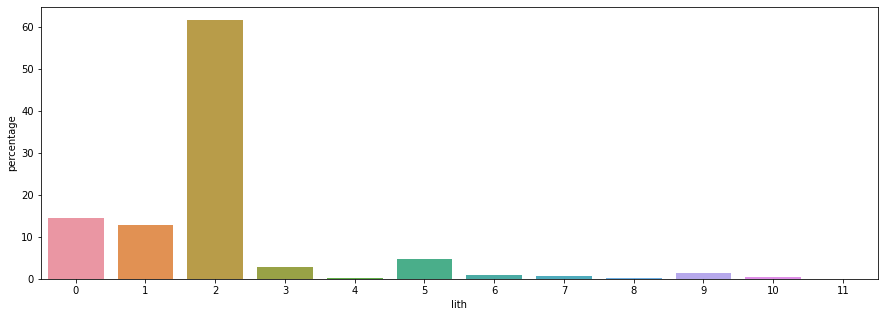

In [ ]:
lith_counts = y_test.value_counts().reset_index()
lith_counts.columns = ['lith_id', 'counts']
lith_counts['lith'] = lith_counts['lith_id']
lith_counts['percentage'] = (lith_counts['counts']/lith_counts['counts'].sum()*100)
plt.figure(figsize=(15,5))
sns.barplot(x='lith',y='percentage',data=lith_counts)


In [ ]:
A = np.load('penalty_matrix.npy')

In [ ]:
def score(y_true, y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

# Random Forest Model

In [ ]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
y_pred_test_rf = rf_model.predict(X_test)
score(y_test.values, y_pred_test_rf)

-0.22092669976473955

In [ ]:
rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

plt.figure(figsize=(15,15))
plt.matshow(confusion_matrix(y_test.values, y_pred_test), cmap="Blues")
plt.colorbar(shrink=0.8)
plt.xticks(range(10))
plt.yticks(range(10))
plt.xlabel("Predicted label")
plt.ylabel("True label");

In [ ]:
test_features = test[['DEPTH_MD', 'CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'DTC', 'SP', 'DRHO']]
test_features = test_features.fillna(0)

In [ ]:
test_prediction_rf = rf_model.predict(test_features)
test_prediction_rf

array([1, 1, 1, ..., 2, 2, 2], dtype=int64)

In [ ]:
category_to_lithology = {y:x for x,y in lithology_numbers.items()}
test_prediction_for_submission = np.vectorize(category_to_lithology.get)(test_prediction_rf)
test_prediction_for_submission
np.savetxt('test_predictions_rf.csv', test_prediction_for_submission, header='lithology', comments='', fmt='%i')

# XGBoost Model

In [ ]:
xgb_model = xgb.XGBClassifier()

params = { "eta" : [0.10, 0.20, 0.30 ] , "max_depth" : [ 5, 10, 15], "min_child_weight" : [ 1, 3, 5 ], "gamma" : [ 0.1, 0.2 , 0.3], "colsample_bytree" : [ 0.3, 0.4, 0.5] }

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=5, cv=3, verbose=3, n_jobs=1, return_train_score=True)

search.fit(X_train, y_train)

In [ ]:
search.best_params_

{'colsample_bytree': 0.5,
 'eta': 0.3,
 'gamma': 0.2,
 'max_depth': 15,
 'min_child_weight': 3}

In [ ]:
xgbmodel_3=xgb.XGBClassifier(objective="multi:softmax", random_state=42, colsample_bytree= 0.5, eta= 0.3, gamma= 0.2, max_depth= 15, min_child_weight= 3)
xgbmodel_3.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=0.3, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# stratified k-fold cross validation evaluation of xgboost model
kfold = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
results = cross_val_score(xgbmodel_3, X_train, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Accuracy: 89.87% (0.10%)


In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
results_2 = cross_val_score(xgbmodel_3, X_train, y_train, cv=kfold, scoring='f1_weighted')

F1 Score: 89.87% (0.10%)


In [ ]:
results_2

array([0.89422363, 0.89689736, 0.89376203, 0.89546541, 0.89607303])

In [ ]:
xtest_pred = xgbmodel_3.predict(X_test)

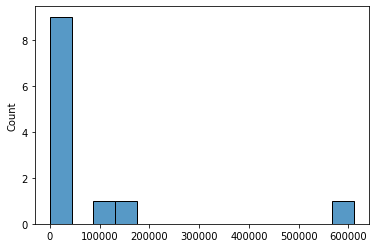

In [ ]:
lith_counts = np.bincount(xtest_pred)
sns.histplot(np.bincount(xtest_pred))

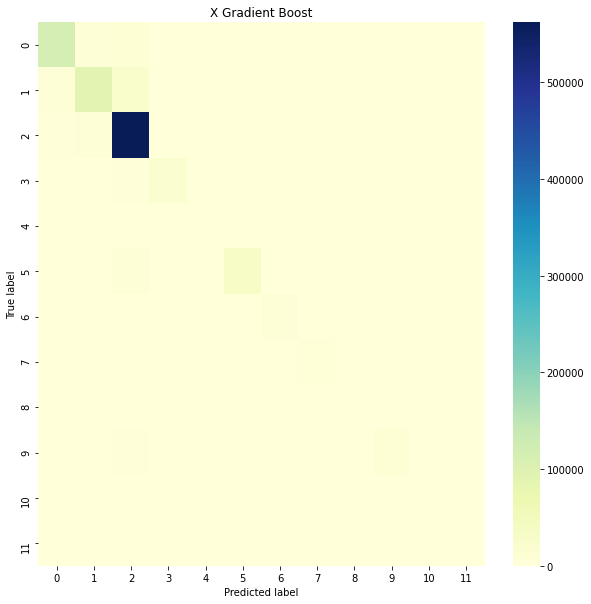

In [ ]:
cm = confusion_matrix(y_test, xtest_pred) 

cm_df = pd.DataFrame(cm)

plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=False,cmap="YlGnBu")
plt.title('X Gradient Boost')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
group_dummies = pd.get_dummies(test.GROUP)
test = pd.concat([test, group_dummies],axis=1)

In [ ]:
test_features = test[['DEPTH_MD', 'RMED', 'RDEP', 'RHOB', 'GR', 'DTC', 'RHOB', 'DRHO','BAAT GP.', 
                        'CROMER KNOLL GP.', 'DUNLIN GP.', 'HEGRE GP.', 'HORDALAND GP.','NORDLAND GP.', 'ROGALAND GP.',
                        'SHETLAND GP.','VESTLAND GP.', 'VIKING GP.', 'ZECHSTEIN GP.',]]

In [ ]:
test_features = test_features.fillna(0)
test_features = np.asarray(test_features)

In [ ]:
test_prediction_xgb_3 = xgbmodel_3.predict(test_features)
test_prediction_xgb_3

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
category_to_lithology = {y:x for x,y in lithology_numbers.items()}
test_prediction_for_submission = np.vectorize(category_to_lithology.get)(test_prediction_xgb_3)
test_prediction_for_submission
np.savetxt('test_predictions_xgb_3.csv', test_prediction_for_submission, header='lithology', comments='', fmt='%i')

#With Optional Weighting to balance classes

In [ ]:
largest_class_weight_coef = y_train.value_counts().iloc[0]
largest_class_weight_coef

144160

In [ ]:
largest_class_weight_coef = y_train.value_counts().iloc[0]
largest_class_weight_coef

def CreateBalancedSampleWeights(y_train, largest_class_weight_coef):
    classes = y_train.unique()
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in y_train]

    return sample_weights

In [ ]:
train_sample_weight = CreateBalancedSampleWeights(y_train, largest_class_weight_coef)

In [ ]:
xgbmodel_3.fit(X_train, y_train, sample_weight=train_sample_weight)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=0.3, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

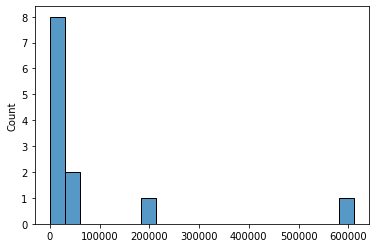

In [ ]:
xtest_pred_3 = xgbmodel_3.predict(X_test)
sns.histplot(np.bincount(xtest_pred_3))

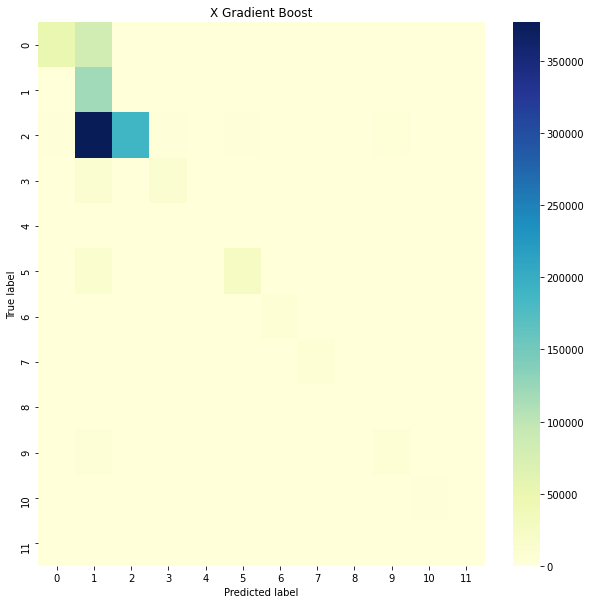

In [ ]:
cm = confusion_matrix(y_test, xtest_pred_3) 

cm_df = pd.DataFrame(cm)

plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=False,cmap="YlGnBu")
plt.title('X Gradient Boost')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
test_prediction_xgb_3 = xgbmodel_3.predict(test_features)
test_prediction_xgb_3

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
category_to_lithology = {y:x for x,y in lithology_numbers.items()}
test_prediction_for_submission = np.vectorize(category_to_lithology.get)(test_prediction_xgb_3)
test_prediction_for_submission
np.savetxt('test_predictions_xgb_3new.csv', test_prediction_for_submission, header='lithology', comments='', fmt='%i')